## Answer Prediction Dataset: Question & Answering

Dataset Source: https://www.kaggle.com/datasets/a2m2a2n2/question-answer-dataset

#### Import Necessary Libraries

In [1]:
import os, sys, random, collections, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel, Sequence

import transformers
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, set_seed
from transformers import TrainingArguments, Trainer, default_data_collator

import torch

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.7 
         NumPy: 1.23.3
      Datasets: 2.8.0
  Transformers: 4.26.1
      Evaluate: 0.2.2
         Torch: 1.12.1


#### Load & Start Processing Dataset

In [3]:
parent_dir = "/Users/leedunn/Desktop/Projects_to_Train/Object Detection"

data = pd.read_csv(os.path.join(parent_dir, "Question_Answer.csv"))

# only keep samples which has answers
data = data[data["Answer_possible"] == True]

# Rename Features as needed
data.rename(columns={
    "Answer_start": "answer_start", 
    "Answer_text": "answer_text",
    "Question": "question",
    "Paragraph" : "context"
    }, inplace=True)

# Remove unnecessary Features
data.drop(columns=["Theme", "Answer_possible"], inplace=True)

# Concatenate the Answer_text & Answer_start into a dictionary in column named "answer"
data["answers"] =  "{\"text\": " + data["answer_text"] + ", \"answer_start\": " + data["answer_start"] + "}"

data["answers"] = data["answers"].apply(lambda x: ast.literal_eval(x))

data.drop(columns=["answer_text", "answer_start"], inplace=True)

data['id'] = data.index.astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50125 entries, 0 to 74856
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   50125 non-null  object
 1   question  50125 non-null  object
 2   answers   50125 non-null  object
 3   id        50125 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


#### Example

In [4]:
n = 5000
print(f"Context: {data['context'][n]}")
print(f"\nQuestion: {data['question'][n]}")

Context: The current administration presides over an uneasy internal peace and faces difficult economic problems of stimulating recovery and reducing poverty, despite record-high oil prices since 2003. Natural gas and diamonds are also recent major Congolese exports, although Congo was excluded from the Kimberley Process in 2004 amid allegations that most of its diamond exports were in fact being smuggled out of the neighboring Democratic Republic of Congo; it was re-admitted to the group in 2007.

Question: When was the Congo allowed back into the Kimberley Process?


#### Visual: Histogram of Input Lengths

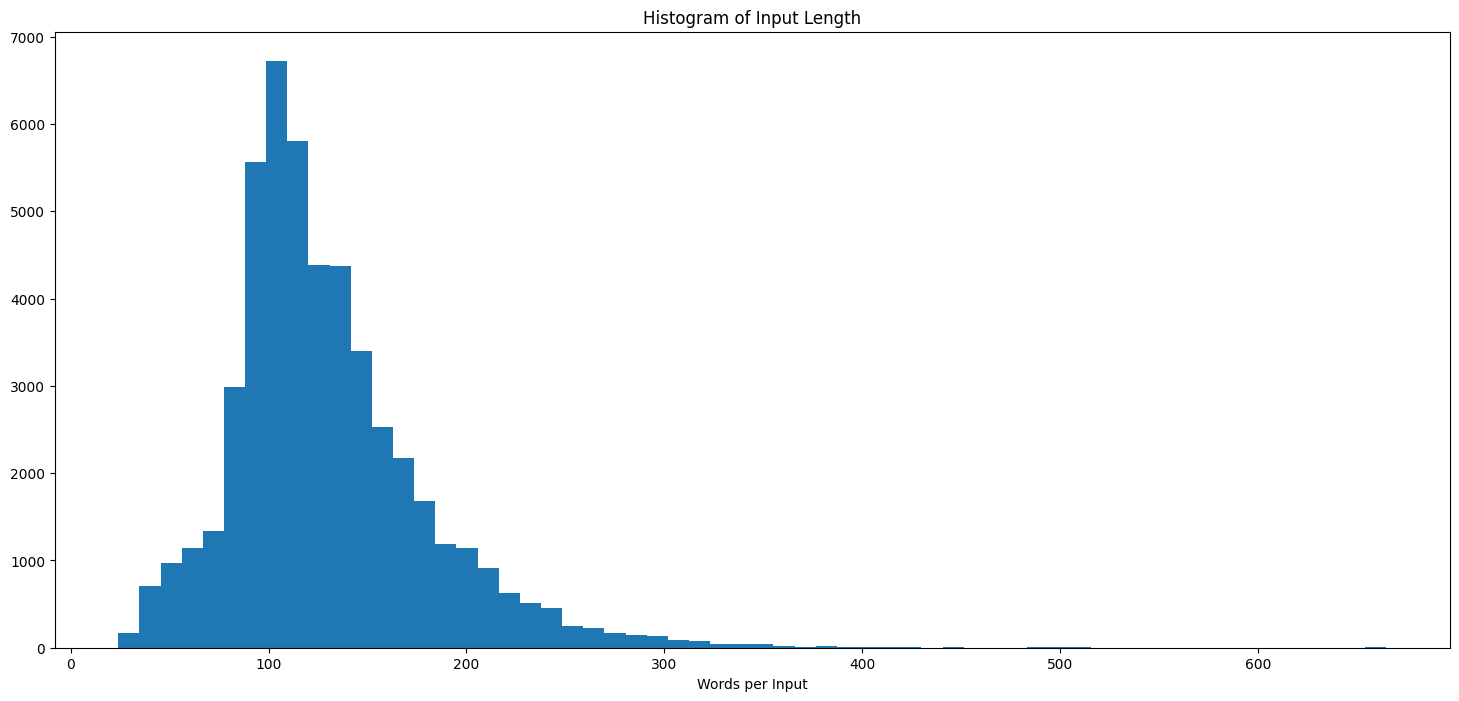

In [5]:
para_n_question = pd.DataFrame()
para_n_question["input"] = data["context"] + data["question"]
para_n_question["input_len"] = para_n_question['input'].str.split().str.len()
max(para_n_question["input_len"])

para_n_question.hist('input_len', grid=False, bins=60, figsize=(18,8))
plt.suptitle('')
plt.title('Histogram of Input Length')
plt.ylabel('')
plt.xlabel('Words per Input')
plt.show()

para_n_question.drop(columns=["input", "input_len"], inplace=True)

#### Convert DataFrame to Dataset

In [6]:
dataset = Dataset.from_pandas(data)

dataset

Dataset({
    features: ['context', 'question', 'answers', 'id', '__index_level_0__'],
    num_rows: 50125
})

#### Split Dataset into Training & Evaluation Datasets

In [7]:
train_testvalid = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'eval' : train_testvalid['test']
})

print('Training data shape:', ds['train'].shape)
print('Evaluation data shape:', ds['eval'].shape)
print(ds['train'].features)

Training data shape: (40100, 5)
Evaluation data shape: (10025, 5)
{'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': {'answer_start': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, 'id': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Basic Values/Constants

In [8]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-question_and_answer"

MAX_LENGTH = 384
DOC_STRIDE = 128

DEVICE = torch.device("cpu")

BATCH_SIZE = 64
set_seed(42)

LEARNING_RATE = 2e-5
NUM_OF_EPOCH = 3

WEIGHT_DECAY = 0.01

#### Function to Preprocess Training Dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def preprocess_training_ds(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=MAX_LENGTH,
        truncation="only_second",
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start & end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Else it is the start & end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

#### Apply Training Preprocessing Function to Training Dataset

In [10]:
train_ds = ds["train"].map(
    preprocess_training_ds,
    batched=True,
    remove_columns=ds["train"].column_names,
)

len(ds["train"]), len(train_ds)

  0%|          | 0/41 [00:00<?, ?ba/s]

(40100, 40554)

In [11]:
def preprocess_validation_ds(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=MAX_LENGTH,
        truncation="only_second",
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

#### Apply Preprocessing Function to Evaluation Dataset

In [12]:
eval_ds = ds["eval"].map(
    preprocess_validation_ds,
    batched=True,
    remove_columns=ds["eval"].column_names,
)
len(ds["eval"]), len(eval_ds)

  0%|          | 0/11 [00:00<?, ?ba/s]

(10025, 10113)

#### Create Function to Evaluate Model (Compute Metrics)

In [13]:
metric = evaluate.load("squad")
n_best = 20
max_answer_length = 30

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

#### Instantiate Model

In [14]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [15]:
args = TrainingArguments(
    MODEL_NAME,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCH,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=True
)

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-question_and_answer into local empty directory.


In [17]:
trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 40554
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15210
  Number of trainable parameters = 108893186


  0%|          | 0/15210 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.9395, 'learning_rate': 1.9342537804076265e-05, 'epoch': 0.1}
{'loss': 1.7226, 'learning_rate': 1.8685075608152533e-05, 'epoch': 0.2}
{'loss': 1.4624, 'learning_rate': 1.80276134122288e-05, 'epoch': 0.3}
{'loss': 1.4056, 'learning_rate': 1.7370151216305063e-05, 'epoch': 0.39}
{'loss': 1.3203, 'learning_rate': 1.671268902038133e-05, 'epoch': 0.49}
{'loss': 1.2649, 'learning_rate': 1.6055226824457594e-05, 'epoch': 0.59}
{'loss': 1.2347, 'learning_rate': 1.539776462853386e-05, 'epoch': 0.69}
{'loss': 1.2236, 'learning_rate': 1.4740302432610125e-05, 'epoch': 0.79}
{'loss': 1.1746, 'learning_rate': 1.4082840236686392e-05, 'epoch': 0.89}
{'loss': 1.2067, 'learning_rate': 1.3425378040762658e-05, 'epoch': 0.99}


Saving model checkpoint to bert-base-uncased-question_and_answer/checkpoint-5070
Configuration saved in bert-base-uncased-question_and_answer/checkpoint-5070/config.json
Model weights saved in bert-base-uncased-question_and_answer/checkpoint-5070/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-question_and_answer/checkpoint-5070/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/checkpoint-5070/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-question_and_answer/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.8849, 'learning_rate': 1.2767915844838923e-05, 'epoch': 1.08}
{'loss': 0.7939, 'learning_rate': 1.2110453648915189e-05, 'epoch': 1.18}
{'loss': 0.8559, 'learning_rate': 1.1452991452991454e-05, 'epoch': 1.28}
{'loss': 0.8442, 'learning_rate': 1.0795529257067721e-05, 'epoch': 1.38}
{'loss': 0.83, 'learning_rate': 1.0138067061143987e-05, 'epoch': 1.48}
{'loss': 0.8227, 'learning_rate': 9.48060486522025e-06, 'epoch': 1.58}
{'loss': 0.8064, 'learning_rate': 8.823142669296516e-06, 'epoch': 1.68}
{'loss': 0.7891, 'learning_rate': 8.165680473372781e-06, 'epoch': 1.78}
{'loss': 0.8144, 'learning_rate': 7.508218277449047e-06, 'epoch': 1.87}
{'loss': 0.8424, 'learning_rate': 6.850756081525313e-06, 'epoch': 1.97}


Saving model checkpoint to bert-base-uncased-question_and_answer/checkpoint-10140
Configuration saved in bert-base-uncased-question_and_answer/checkpoint-10140/config.json
Model weights saved in bert-base-uncased-question_and_answer/checkpoint-10140/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-question_and_answer/checkpoint-10140/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/checkpoint-10140/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-question_and_answer/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/special_tokens_map.json


{'loss': 0.6021, 'learning_rate': 6.193293885601579e-06, 'epoch': 2.07}
{'loss': 0.5701, 'learning_rate': 5.535831689677844e-06, 'epoch': 2.17}
{'loss': 0.5489, 'learning_rate': 4.878369493754109e-06, 'epoch': 2.27}
{'loss': 0.5363, 'learning_rate': 4.220907297830375e-06, 'epoch': 2.37}
{'loss': 0.5821, 'learning_rate': 3.563445101906641e-06, 'epoch': 2.47}
{'loss': 0.5356, 'learning_rate': 2.9059829059829063e-06, 'epoch': 2.56}
{'loss': 0.5635, 'learning_rate': 2.2485207100591717e-06, 'epoch': 2.66}
{'loss': 0.5553, 'learning_rate': 1.5910585141354374e-06, 'epoch': 2.76}
{'loss': 0.5547, 'learning_rate': 9.335963182117029e-07, 'epoch': 2.86}
{'loss': 0.5155, 'learning_rate': 2.7613412228796843e-07, 'epoch': 2.96}


Saving model checkpoint to bert-base-uncased-question_and_answer/checkpoint-15210
Configuration saved in bert-base-uncased-question_and_answer/checkpoint-15210/config.json
Model weights saved in bert-base-uncased-question_and_answer/checkpoint-15210/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-question_and_answer/checkpoint-15210/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/checkpoint-15210/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-question_and_answer/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 532317.3501, 'train_samples_per_second': 0.229, 'train_steps_per_second': 0.029, 'train_loss': 0.9549857636802217, 'epoch': 3.0}


TrainOutput(global_step=15210, training_loss=0.9549857636802217, metrics={'train_runtime': 532317.3501, 'train_samples_per_second': 0.229, 'train_steps_per_second': 0.029, 'train_loss': 0.9549857636802217, 'epoch': 3.0})

#### Compute & Display Metrics

In [18]:
predictions, _, _ = trainer.predict(eval_ds)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, eval_ds, ds["eval"])

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10113
  Batch size = 8


  0%|          | 0/1265 [00:00<?, ?it/s]

  0%|          | 0/10025 [00:00<?, ?it/s]

{'exact_match': 65.7356608478803, 'f1': 79.28347788592988}

#### Push Model to Hub

In [19]:
trainer.push_to_hub(commit_message="All DUNN!!!")

Saving model checkpoint to bert-base-uncased-question_and_answer
Configuration saved in bert-base-uncased-question_and_answer/config.json
Model weights saved in bert-base-uncased-question_and_answer/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-question_and_answer/tokenizer_config.json
Special tokens file saved in bert-base-uncased-question_and_answer/special_tokens_map.json


Upload file runs/Feb28_13-10-33_Lees-Air/events.out.tfevents.1677611439.Lees-Air.8335.0: 100%|##########| 8.71…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-question_and_answer
   f10f78f..13ce860  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}}
To https://huggingface.co/DunnBC22/bert-base-uncased-question_and_answer
   13ce860..b704d7a  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-question_and_answer/commit/13ce860448e69412d6a88c866d7d7d67ad99f311'

### Notes & Other Takeaways
****
- This model turned out better than I expected.
****

### Citations
- Model Checkpoint
    - @article{DBLP:journals/corr/abs-1810-04805,
  author    = {Jacob Devlin and
               Ming{-}Wei Chang and
               Kenton Lee and
               Kristina Toutanova},
  title     = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language
               Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
****
- Metric (SQuAD)
  - @inproceedings{Rajpurkar2016SQuAD10,
title={SQuAD: 100, 000+ Questions for Machine Comprehension of Text},
author={Pranav Rajpurkar and Jian Zhang and Konstantin Lopyrev and Percy Liang},
booktitle={EMNLP},
year={2016}
}